In [1]:
%load_ext autoreload
%autoreload 2

from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df, create_continuity_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

continuity = create_continuity_df('data/raw/continuity.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]
small_test = (test_caregivers, test_tasks)

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]
car_test = (car_caregivers, car_tasks)

full_test = (caregivers, tasks)

print(len(car_caregivers))
print(len(car_tasks))
# Get the number of unique clients in the car_tasks dataset
car_clients = car_tasks['ClientID'].nunique()
print(f"Number of unique clients: {car_clients}")


17
160
Number of unique clients: 60


In [ ]:
from models.fixed_model import FixedModel
from models.tsp_model import TSPModel
from models.hexaly_break_model import HexalyBreakModel
from models.hexaly_model import HexalyModel
from models.tsp_model_strict import TSPModelStrict
model_type = HexalyBreakModel
model_caregivers, model_tasks = small_test

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix, continuity)
model.build(
        # caregiver_penalty=0,
        # overtime_penalty=0,
        # worktime_per_break=0,
        # continuity_penalty=0,
        # warm_start=True
        time_limit = 3,
)
# model.optimize()

Push initial solution 100%
Model:  expressions = 7003, decisions = 35, constraints = 187, objectives = 2
Param:  time limit = 30 sec, no iteration limit

[objective directions]:     minimize |     minimize

[  0 sec,       0 itr]: No feasible solution found (infeas = 1)
[  1 sec,   12059 itr]:      2745.48 |      31558.5
[  2 sec,   89409 itr]:            0 |      22105.4
[  3 sec,  177617 itr]:            0 |      19318.5
[  4 sec,  256464 itr]:            0 |      18184.4
[  5 sec,  341244 itr]:            0 |      17767.4
[  6 sec,  424040 itr]:            0 |      17008.5
[  7 sec,  511524 itr]:            0 |      16524.5
[  8 sec,  598414 itr]:            0 |      16288.3
[  9 sec,  684507 itr]:            0 |        16159
[ 10 sec,  771889 itr]:            0 |      15898.2
[ optimality gaps    ]:           0% |      100.00%
[ 11 sec,  859574 itr]:            0 |      15648.6
[ 12 sec,  950547 itr]:            0 |      15499.5
[ 13 sec, 1032902 itr]:            0 |      14861.3
[

IndexError: list index out of range

/Users/vilhelmkarlin/Code/KTH/SA120X_KEX/utils/visualization.py:857: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dashboard_fig.show()


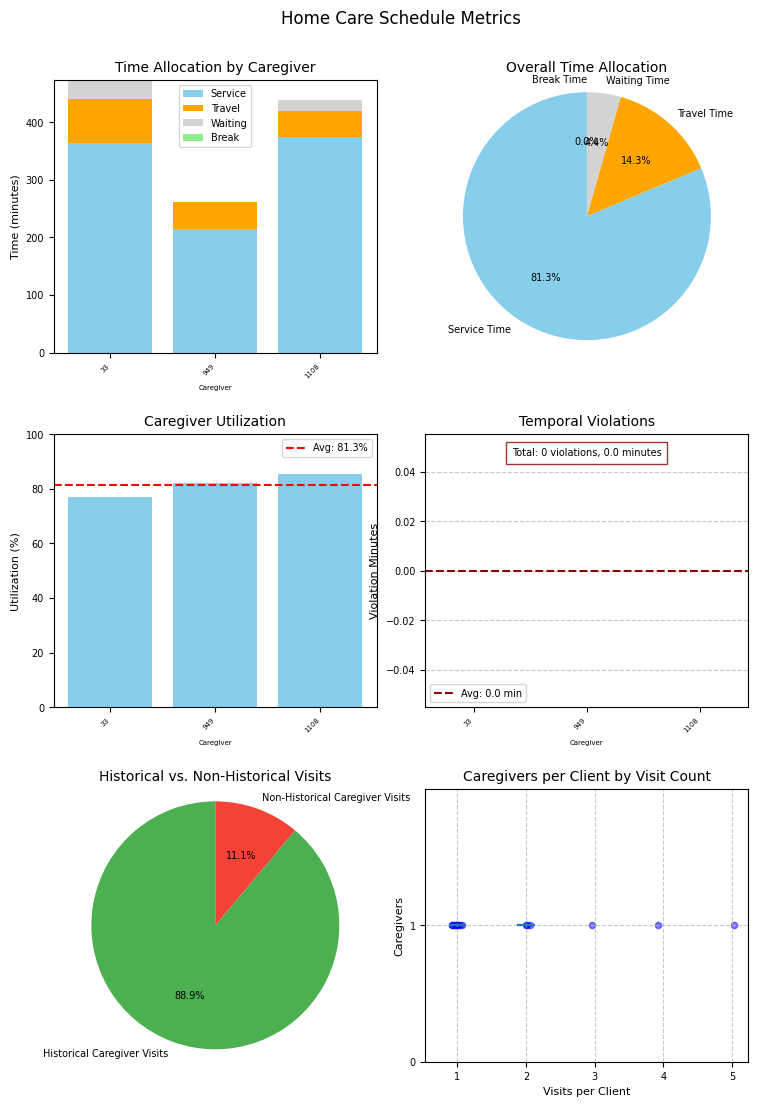

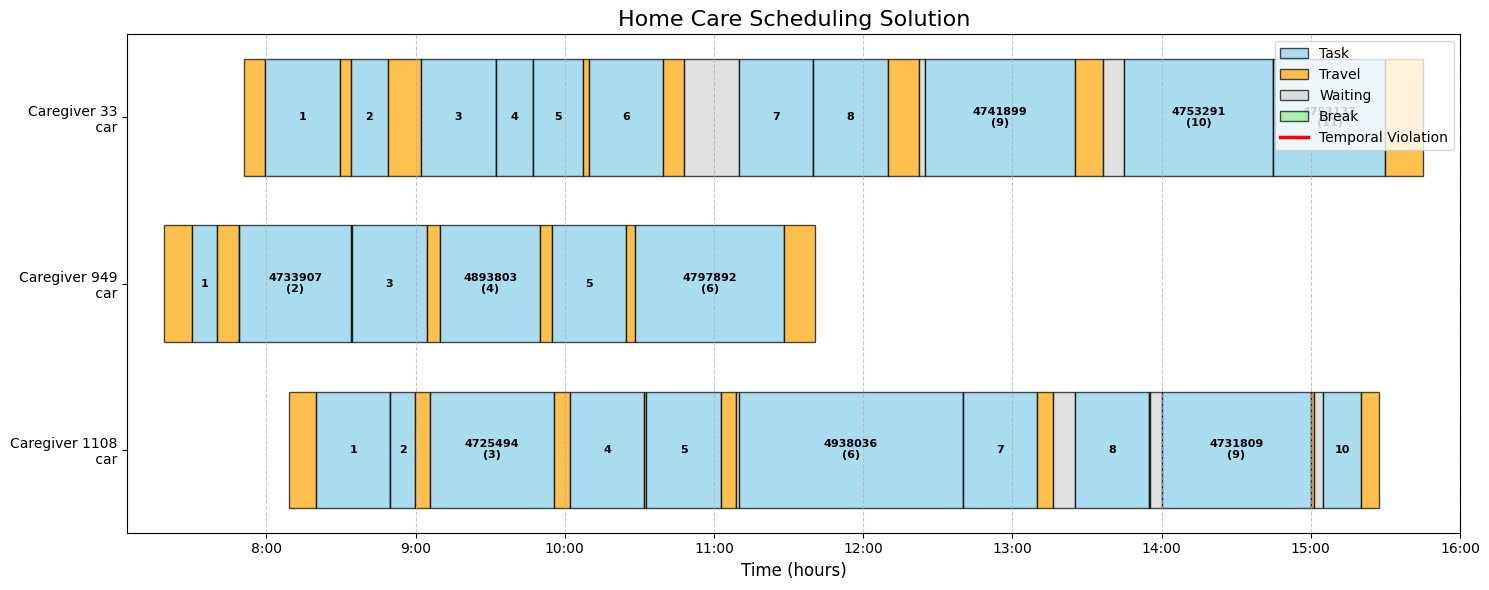

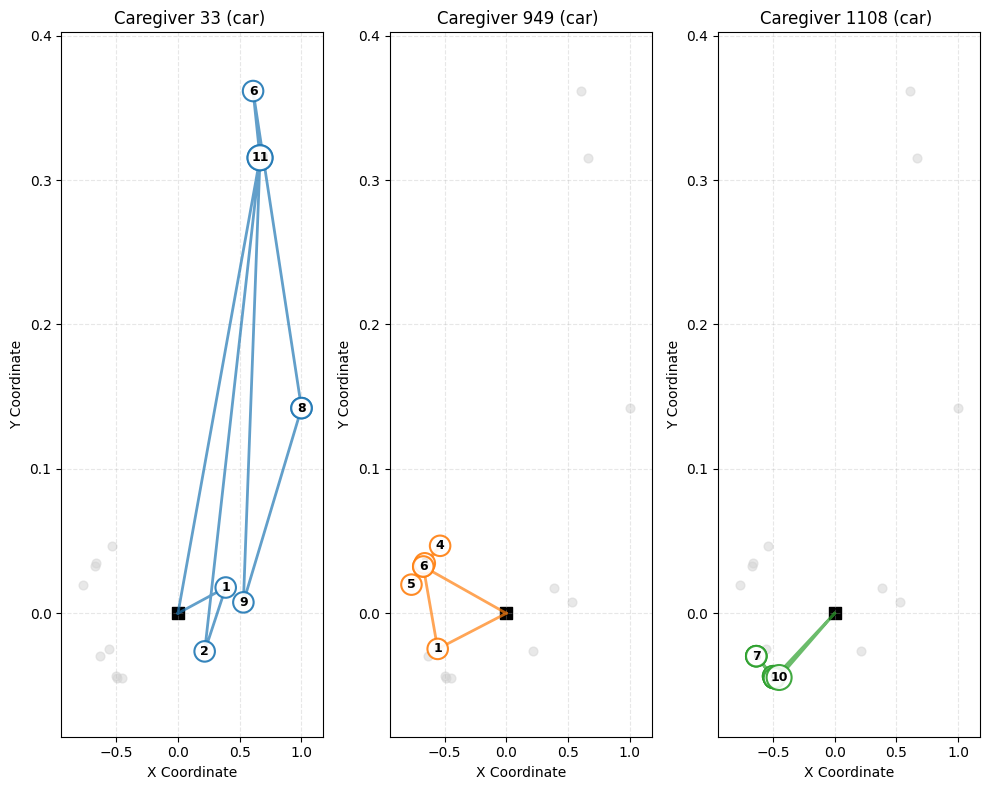

In [90]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes, display_metrics_summary

model.get_solution()

metrics_plot = visualize_metrics(model, display_mode='dashboard');
schedule_plot = visualize_schedule(model);
route_plot = visualize_routes(model, caregiver_ids=None, subplot_mode=True);
#display_metrics_summary(model)

In [ ]:
import matplotlib.pyplot as plt
plt.savefig("figures/base_metrics.pdf", format="pdf", bbox_inches="tight")
plt.savefig("figures/base_schedule.pdf", format="pdf", bbox_inches="tight")
plt.savefig("figures/base_route.pdf", format="pdf", bbox_inches="tight")



In [6]:
from utils.solution_storage import save_solution
save_solution(model, 'overtime_penalty_1-lateness_5-caregiver_60')

Solution saved to data/saved_solutions/20250413_002553_overtime_penalty_1-lateness_5-caregiver_60.json


'data/saved_solutions/20250413_002553_overtime_penalty_1-lateness_5-caregiver_60.json'

/Users/vilhelmkarlin/Code/KTH/SA120X_KEX/utils/visualization.py:857: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dashboard_fig.show()


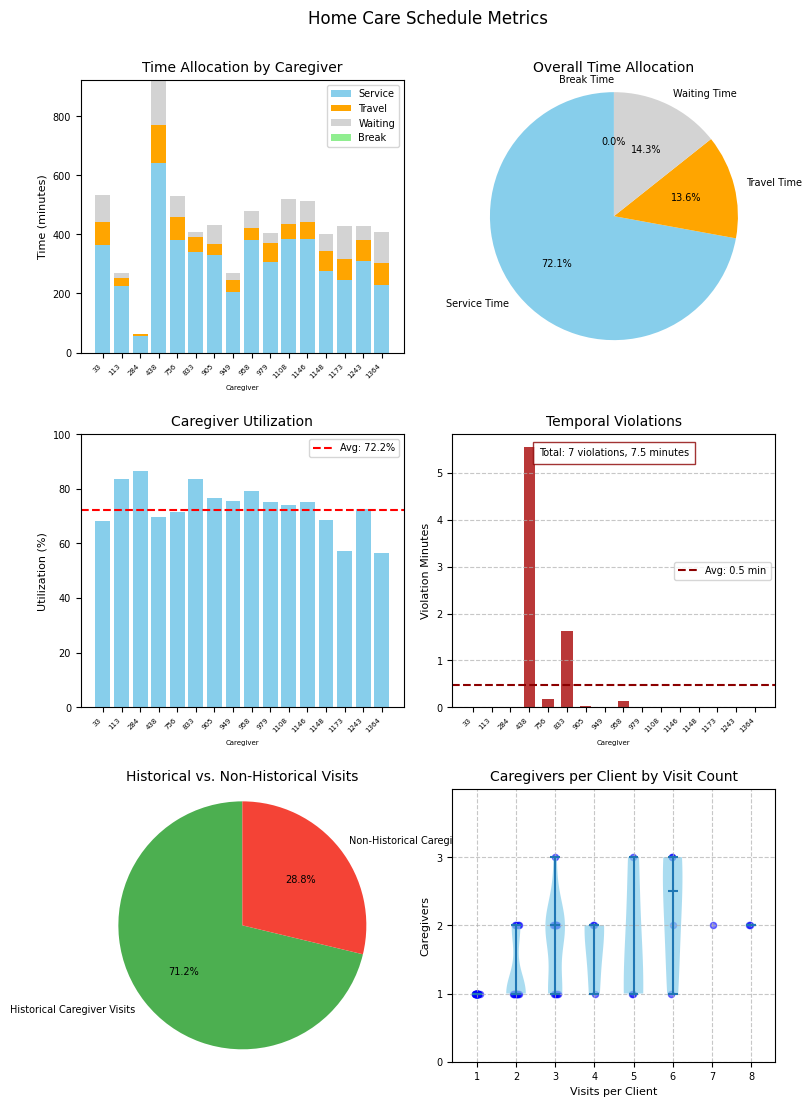

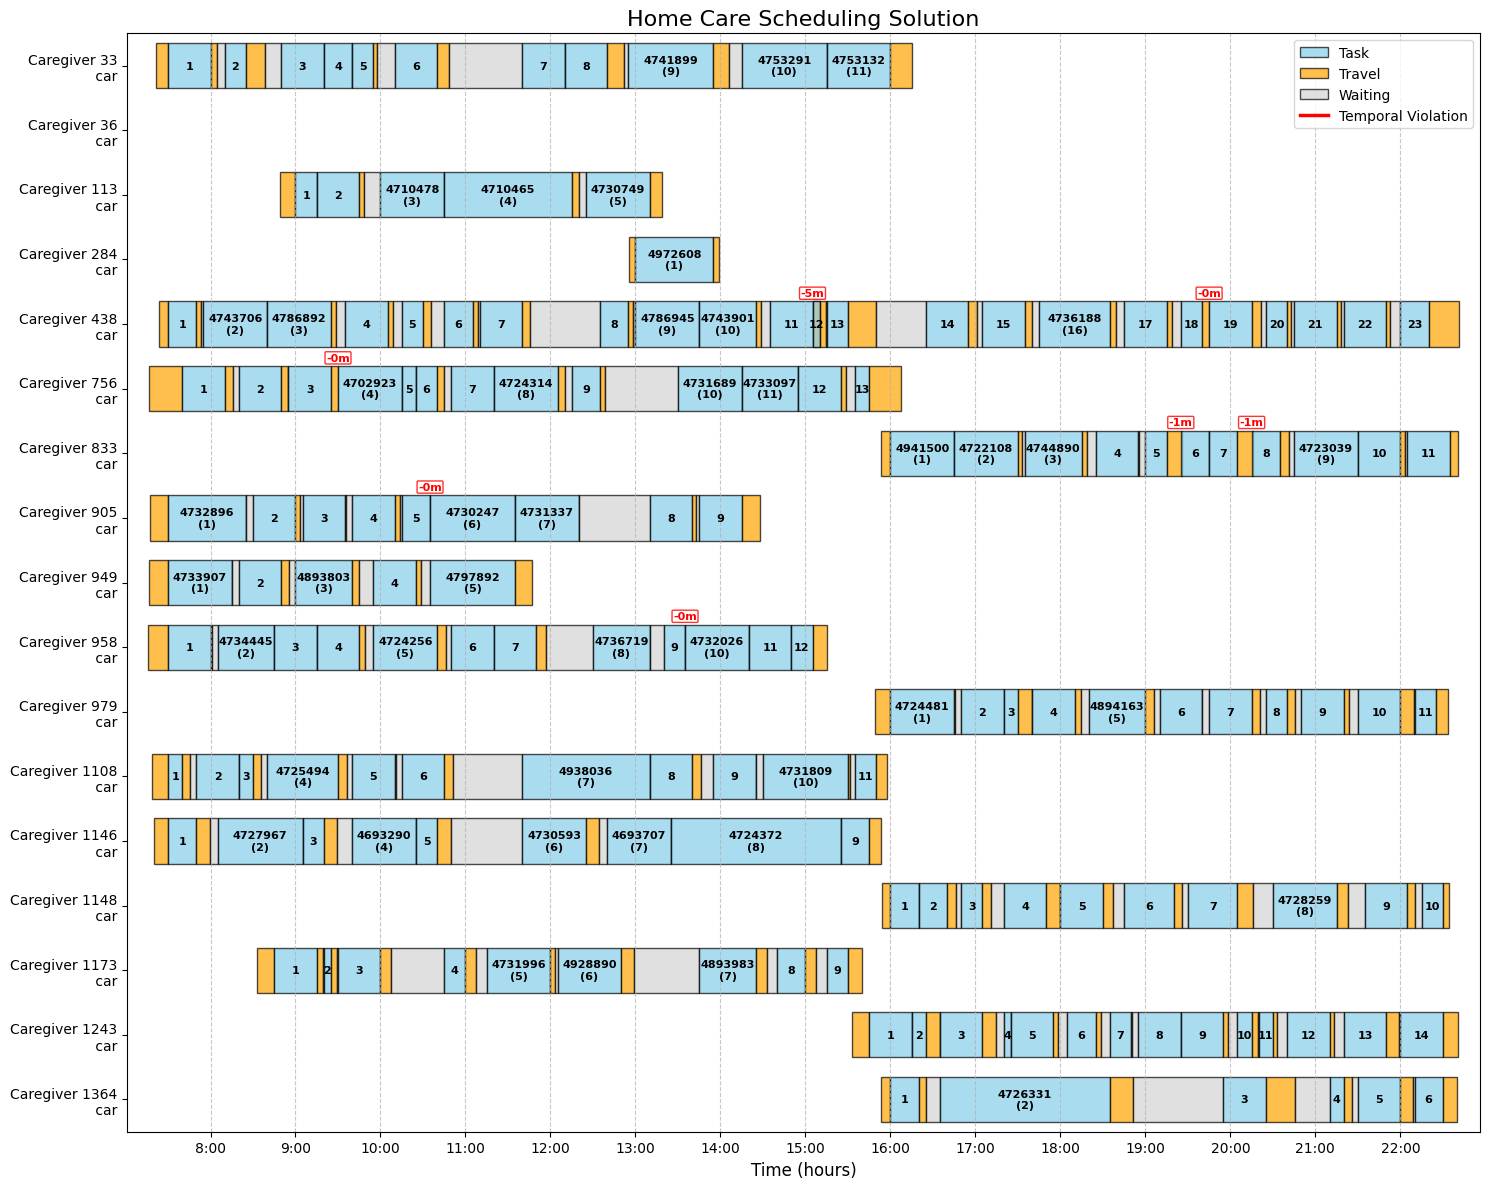

In [49]:
from utils.solution_storage import create_model_from_real_data

real_data_model = create_model_from_real_data(model.caregivers, model.tasks, model.clients, model.drive_time_matrix, model.walk_time_matrix, model.bicycle_time_matrix, model.continuity)

# display_metrics_summary(real_data_model)
visualize_metrics(real_data_model, display_mode='dashboard');
visualize_schedule(real_data_model);
# visualize_routes(real_data_model, caregiver_ids=None, subplot_mode=True)


In [59]:
sum(real_data_model.s.values()) * (4/3) /(5*60)

np.float64(22.466666666666665)